In [8]:
from __future__ import division #always returns approximations from divisions
import numpy as np
import matplotlib.pyplot as plt
import ephem #for astronomy calculations, converting coordinate systems
import pandas as pd
from astroquery.gaia import Gaia
import math

In [9]:
v_df = pd.read_csv('nh_ephemeris.csv') #new horizons ephemeris 
s_df = pd.DataFrame(columns = ['source_id', 'ra', 'dec', 'g_abs', 'bp_rp', 'parallax', 'parallax_error', 'dist', 'date', 'pmra', 'pmdec', 'adv_ra', 'adv_dec', 'eph_pt']) #empty dataframe for encountered stars

In [10]:
v_df['year'] = 0
v_df['month'] = 0
v_df['day'] = 0
v_df['hour'] = 0
v_df['min'] = 0
v_df['sec'] = 0
v_df['total_time'] = 0
v_df['time_lasts'] = 0

for i in range(len(v_df.index)):
    v_df['year'][i] = float(v_df['date'][i][:4])
    v_df['month'][i] = v_df['date'][i][5:8]
    v_df['day'][i] = float(v_df['date'][i][9:11])
    v_df['hour'][i] = float(v_df['date'][i][12:14])
    v_df['min'][i] = float(v_df['date'][i][15:17])
    v_df['sec'][i] = v_df['date'][i][18:]
    
    if v_df['month'][i] == "Jan":
        v_df['month'][i] = 0
        
    elif v_df['month'][i] == "Feb":
        v_df['month'][i] = 1
        
    elif v_df['month'][i] == "Mar":
        v_df['month'][i] = 2
        
    elif v_df['month'][i] == "Apr":
        v_df['month'][i] = 3
        
    elif v_df['month'][i] == "May":
        v_df['month'][i] = 4
        
    elif v_df['month'][i] == "Jun":
        v_df['month'][i] = 5
        
    elif v_df['month'][i] == "Jul":
        v_df['month'][i] = 6
        
    elif v_df['month'][i] == "Aug":
        v_df['month'][i] = 7
        
    elif v_df['month'][i] == "Sep":
        v_df['month'][i] = 8
        
    elif v_df['month'][i] == "Oct":
        v_df['month'][i] = 9
        
    elif v_df['month'][i] == "Nov":
        v_df['month'][i] = 10
        
    elif v_df['month'][i] == "Dec":
        v_df['month'][i] = 11
    
    #calc total time (since 0/0/0) in seconds
    v_df['total_time'][i] = v_df['year'][i] * 31536000 + v_df['month'][i] * 2628288 + v_df['day'][i] * 86400 + v_df['hour'][i] * 3600 + v_df['min'][i] * 60 + float(v_df['sec'][i])
    
for i in range(len(v_df.index)-1):    
    v_df['time_lasts'][i] = v_df['total_time'][i+1] - v_df['total_time'][i]
    
print(v_df)

<ipython-input-10-bdaabe8958ac>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v_df['year'][i] = float(v_df['date'][i][:4])
<ipython-input-10-bdaabe8958ac>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v_df['month'][i] = v_df['date'][i][5:8]
/Users/mikeyd1050/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-inp

      Unnamed: 0                      date         ra       dec  year month  \
0              0  2006-Jan-20 00:00:00.000  207.08781 -10.02864  2006     0   
1              1  2006-Jan-20 00:13:54.276  207.19701  -9.97212  2006     0   
2              2  2006-Jan-20 00:29:30.543  207.30739  -9.91493  2006     0   
3              3  2006-Jan-20 00:46:49.544  207.41706  -9.85803  2006     0   
4              4  2006-Jan-20 01:06:09.506  207.52607  -9.80141  2006     0   
...          ...                       ...        ...       ...   ...   ...   
1855          18  2024-Aug-12 21:40:26.760  288.70597 -20.29126  2024     7   
1856          19  2024-Aug-22 15:57:34.445  288.58007 -20.30985  2024     7   
1857          20  2024-Sep-02 22:09:23.605  288.45960 -20.32905  2024     8   
1858          21  2024-Sep-17 05:18:42.993  288.35209 -20.34893  2024     8   
1859          22  2024-Oct-11 00:15:46.947  288.30129 -20.36808  2024     9   

      day  hour  min     sec   total_time  time_las

In [4]:
#Cone search using max radius on first position in ephemeris
for i in range(len(v_df.index)):
    query = """SELECT source_id, ra, dec, phot_g_mean_mag+5*log10(parallax/1000)+5 AS g_abs, (phot_bp_mean_mag - phot_rp_mean_mag) AS bp_rp, parallax, parallax_error, 1000/parallax AS dist, pmra, pmdec
    FROM external.gaiaedr3_gcns_main_1
    WHERE 1=CONTAINS(
    POINT('ICRS', ra, dec),
    CIRCLE('ICRS', """ + str(v_df['ra'][i]) + """,""" + str(v_df['dec'][i]) + """, 0.4527778))
    AND parallax > 0
    """

    results = Gaia.launch_job_async(query).get_results() #results from gaia query
    results = results.to_pandas().dropna() #convert to pandas

    results['date'] = v_df['date'][i]
    results['eph_pt'] = i; #stores which row in ephemeris from

    s_df = pd.concat([s_df, results], ignore_index = True)

print(s_df)

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [5]:
#Advance stars in list with motion
s_df['adv_ra'] = s_df['ra'] + 3.26*s_df['dist']*s_df['pmra']/1000*(0.000277778)
s_df['adv_dec'] = s_df['dec'] + 3.26*s_df['dist']*s_df['pmdec']/1000*(0.000277778)

print(s_df)

                 source_id          ra        dec      g_abs     bp_rp  \
0      3617019838042378880  206.973907 -10.075723   9.739266  2.674937   
1      3617174864886750336  207.201584  -9.660208  13.781791  3.919952   
2      3617000390430452480  207.382929 -10.198071   9.830778  2.564347   
3      3617099136022894848  207.375929 -10.078717  11.902760  0.009192   
4      3617019838042378880  206.973907 -10.075723   9.739266  2.674937   
...                    ...         ...        ...        ...       ...   
10307  4083653599374456832  288.284907 -20.421038  10.452149  2.525453   
10308  4083653603675326080  288.288150 -20.421883   2.905939  0.598045   
10309  4082893119584475008  288.663329 -20.628526  12.233420  2.677380   
10310  4082923283128273536  288.676648 -20.430842  12.202941  3.066299   
10311  4083676384182912128  288.723578 -20.323405   9.784625  2.617345   

        parallax  parallax_error       dist                      date  \
0      12.170426        0.025310  82.1

In [6]:
#Check that advanced ra and dec are within actual cone

final_stars = pd.DataFrame(columns = ['source_id', 'ra', 'dec', 'g_abs', 'bp_rp', 'parallax', 'parallax_error', 'dist', 'date', 'pmra', 'pmdec', 'adv_ra', 'adv_dec', 'eph_pt'])

for i in range(len(s_df.index)):
    dist = math.sqrt((v_df['ra'][s_df['eph_pt'][i]] - s_df['adv_ra'][i])**2 + (v_df['dec'][s_df['eph_pt'][i]] - s_df['adv_dec'][i])**2) #calculate distance between advanced position and center of beam
    
    if dist < 0.064: #if distance < radius of beam add to final version
        final_stars = final_stars.append(s_df.loc[s_df['source_id'] == s_df['source_id'][i]]) #add star to final version     

In [11]:
final_stars = pd.read_csv('nh_stars_final_dup.csv') #final stars from above were saved in this file

final_stars['time_total'] = 0
final_stars = final_stars[final_stars['dist'] <= 100] #eliminate stars not in 100 pc

final_stars['num'] = 0 

for i in range(len(final_stars.index)):
    final_stars['num'][i] = i  #index of stars
    final_stars['time_total'][i] = v_df['time_lasts'][final_stars['eph_pt'][i]] #time for each search based on ephemeris pt time lasts
    
final_stars = final_stars.drop(['Unnamed: 0'], axis = 1) #drop extra column
    
final_stars.to_csv('nh_stars_final_dup.csv') #save again 
print(final_stars) #all stars with duplicates

final_stars_unique = pd.DataFrame(columns = ['source_id', 'ra', 'dec', 'g_abs', 'bp_rp', 'parallax', 'parallax_error', 'dist', 'date', 'pmra', 'pmdec', 'adv_ra', 'adv_dec', 'eph_pt', 'time_total'])

<ipython-input-11-3fd8f9baada9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_stars['num'][i] = i  #index of stars
<ipython-input-11-3fd8f9baada9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_stars['time_total'][i] = v_df['time_lasts'][final_stars['eph_pt'][i]] #time for each search based on ephemeris pt time lasts


                source_id          ra        dec     g_abs     bp_rp  \
0     3618803417701443072  208.801742  -8.707085  9.196508  2.483362   
1     3618803417701443072  208.801742  -8.707085  9.196508  2.483362   
2     3618803417701443072  208.801742  -8.707085  9.196508  2.483362   
3     3618803417701443072  208.801742  -8.707085  9.196508  2.483362   
4     3618803417701443072  208.801742  -8.707085  9.196508  2.483362   
...                   ...         ...        ...       ...       ...   
5223  4083653603675326080  288.288150 -20.421883  2.905939  0.598045   
5224  4083653603675326080  288.288150 -20.421883  2.905939  0.598045   
5225  4083653603675326080  288.288150 -20.421883  2.905939  0.598045   
5226  4083653603675326080  288.288150 -20.421883  2.905939  0.598045   
5227  4083653603675326080  288.288150 -20.421883  2.905939  0.598045   

       parallax  parallax_error       dist                      date  \
0     28.743696        0.056078  34.790237  2006-Jan-20 14:11:2

In [12]:
num_hit = np.array([])     #number of times a star appears in search, index matches
total_times = np.array([])     #array of total times for each star, index matches

for i in range(len(final_stars.index)):
    if (final_stars['source_id'][i] not in final_stars_unique[['source_id']].to_numpy()):   #if star not in unique database
        final_stars_unique = final_stars_unique.append(final_stars.loc[final_stars['num'] == i]) #add star to unique df
        
        num_hit = np.append(num_hit, 1)  #add 1 hit
        
        total_time = final_stars['time_total'][i]   #add value to total time
        
        for j in range(i+1, len(final_stars.index)):   #search from next star in final_stars to end
            
            if final_stars['source_id'][j] == final_stars['source_id'][i]:    #if same star appears again add time and increase number of hits by 1
                total_time += final_stars['time_total'][j]
                num_hit[-1] += 1
                
        total_times = np.append(total_times, total_time)    #add total time to total times array

final_stars_unique['time_total'] = total_times.tolist()    #add total times and num hit as columns
final_stars_unique['num_hit'] = num_hit.tolist()
print(final_stars_unique)  #dataframe of stars without duplicates and with total times & num hits

                source_id          ra        dec      g_abs     bp_rp  \
0     3618803417701443072  208.801742  -8.707085   9.196508  2.483362   
11    3618810628952377216  208.777721  -8.624116  10.280616  2.491736   
16    3618810628950468736  208.778338  -8.622554   6.726190  1.334398   
21    3619803629685075840  207.085235  -8.039468   9.887569  2.782996   
28    3619804557398012544  207.011389  -8.030281  10.729146  2.803044   
...                   ...         ...        ...        ...       ...   
3359  4083653599374456832  288.284907 -20.421038  10.452149  2.525453   
3436  4083653603675326080  288.288150 -20.421883   2.905939  0.598045   
3669  4082923283128273536  288.676648 -20.430842  12.202941  3.066299   
3738  4083676384182912128  288.723578 -20.323405   9.784625  2.617345   
4397  4082930223797532160  289.041144 -20.245098  10.522338  2.790068   

       parallax  parallax_error       dist                      date  \
0     28.743696        0.056078  34.790237  2006-Ja

In [13]:
final_stars_unique.to_csv('nh_results_error.csv') #save again 

In [14]:
print(final_stars.drop_duplicates(subset=['source_id'])) #checking that unique search works, same number

                source_id          ra        dec      g_abs     bp_rp  \
0     3618803417701443072  208.801742  -8.707085   9.196508  2.483362   
11    3618810628952377216  208.777721  -8.624116  10.280616  2.491736   
16    3618810628950468736  208.778338  -8.622554   6.726190  1.334398   
21    3619803629685075840  207.085235  -8.039468   9.887569  2.782996   
28    3619804557398012544  207.011389  -8.030281  10.729146  2.803044   
...                   ...         ...        ...        ...       ...   
3359  4083653599374456832  288.284907 -20.421038  10.452149  2.525453   
3436  4083653603675326080  288.288150 -20.421883   2.905939  0.598045   
3669  4082923283128273536  288.676648 -20.430842  12.202941  3.066299   
3738  4083676384182912128  288.723578 -20.323405   9.784625  2.617345   
4397  4082930223797532160  289.041144 -20.245098  10.522338  2.790068   

       parallax  parallax_error       dist                      date  \
0     28.743696        0.056078  34.790237  2006-Ja

In [15]:
final_stars_unique = final_stars_unique[final_stars_unique['parallax_error'] <= 0.34]
print(final_stars_unique) #final stars accounting for parallax error

final_stars_unique.to_csv('nh_results.csv') #save again 

                source_id          ra        dec      g_abs     bp_rp  \
0     3618803417701443072  208.801742  -8.707085   9.196508  2.483362   
11    3618810628952377216  208.777721  -8.624116  10.280616  2.491736   
16    3618810628950468736  208.778338  -8.622554   6.726190  1.334398   
21    3619803629685075840  207.085235  -8.039468   9.887569  2.782996   
28    3619804557398012544  207.011389  -8.030281  10.729146  2.803044   
...                   ...         ...        ...        ...       ...   
3359  4083653599374456832  288.284907 -20.421038  10.452149  2.525453   
3436  4083653603675326080  288.288150 -20.421883   2.905939  0.598045   
3669  4082923283128273536  288.676648 -20.430842  12.202941  3.066299   
3738  4083676384182912128  288.723578 -20.323405   9.784625  2.617345   
4397  4082930223797532160  289.041144 -20.245098  10.522338  2.790068   

       parallax  parallax_error       dist                      date  \
0     28.743696        0.056078  34.790237  2006-Ja

In [16]:
s_df_og = pd.read_csv('nh_stars.csv') #original star search

print(s_df_og)

     Unnamed: 0  Unnamed: 0.1            source_id          ra        dec  \
0             0             0  3618803417701443072  208.801742  -8.707085   
1             1             1  3618810628952377216  208.777721  -8.624116   
2             2             2  3618810628950468736  208.778338  -8.622554   
3             3             3  3619803629685075840  207.085235  -8.039468   
4             4             4  3619804557398012544  207.011389  -8.030281   
..          ...           ...                  ...         ...        ...   
137         146           204  4083653599374456832  288.284907 -20.421038   
138         147           205  4083653603675326080  288.288150 -20.421883   
139         148           209  4082923283128273536  288.676648 -20.430842   
140         149           210  4083676384182912128  288.723578 -20.323405   
141         150           222  4082930223797532160  289.041144 -20.245098   

         g_abs     bp_rp   parallax  parallax_error       dist  \
0     9.1

In [17]:
s_df_missing = np.array([]) #stars missing from new search
s_df_added = np.array([])  #stars added by new search

og_source = s_df_og['source_id'].to_numpy()    #source ids of og search without error
new_source = final_stars_unique['source_id'].to_numpy()    #source ids of new search without error

print('Missing stars\n')

for i in range(len(og_source)):    #add stars in og but not new search to missing stars array
    if (og_source[i] not in new_source):
        s_df_missing = np.append(s_df_missing, og_source[i])
        
print(s_df_missing)        
print('\nTotal missing: ' + str(s_df_missing.size) + '\n')   #total number missing

print('Added stars\n')

for i in range(len(new_source)):     #add stars in new but not og to added stars array
    if (new_source[i] not in og_source):
        s_df_added = np.append(s_df_added, new_source[i])
        
print(s_df_added)        
print('\nTotal added: ' + str(s_df_added.size) + '\n')    #total number added

Missing stars

[3.63089664e+18 6.30422990e+18 6.30008093e+18 6.24799932e+18
 4.12983670e+18 4.12994744e+18 4.11555872e+18 4.09058757e+18]

Total missing: 8

Added stars

[3.63165283e+18 3.67908940e+18 3.63012024e+18 6.30978628e+18
 6.25818949e+18]

Total added: 5



In [18]:
nh_stars = pd.read_csv('nh_results.csv') #get csv
print(nh_stars)

     Unnamed: 0            source_id          ra        dec      g_abs  \
0             0  3618803417701443072  208.801742  -8.707085   9.196508   
1            11  3618810628952377216  208.777721  -8.624116  10.280616   
2            16  3618810628950468736  208.778338  -8.622554   6.726190   
3            21  3619803629685075840  207.085235  -8.039468   9.887569   
4            28  3619804557398012544  207.011389  -8.030281  10.729146   
..          ...                  ...         ...        ...        ...   
134        3359  4083653599374456832  288.284907 -20.421038  10.452149   
135        3436  4083653603675326080  288.288150 -20.421883   2.905939   
136        3669  4082923283128273536  288.676648 -20.430842  12.202941   
137        3738  4083676384182912128  288.723578 -20.323405   9.784625   
138        4397  4082930223797532160  289.041144 -20.245098  10.522338   

        bp_rp   parallax  parallax_error       dist                      date  \
0    2.483362  28.743696      

<ipython-input-19-02af35b516d2>:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("hot"))
  color_map.set_bad(color='white') #set color as white for masked values


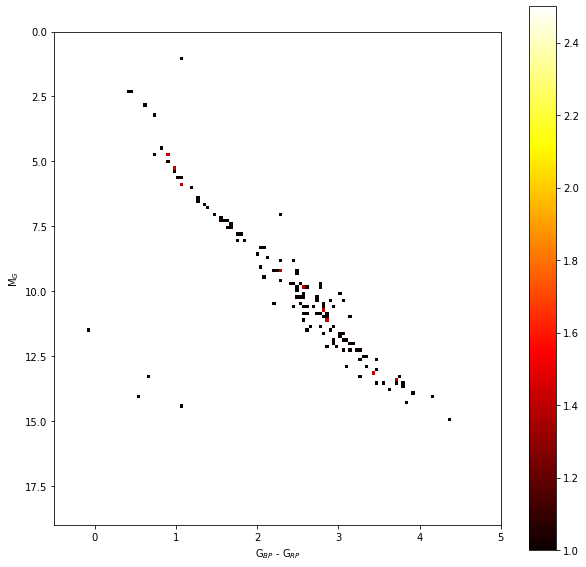

In [19]:
#build hr diagram
histogram, xedges, yedges = np.histogram2d(
   nh_stars['bp_rp'], nh_stars['g_abs'], bins=110)

histogram = np.ma.masked_where(histogram == 0.0, histogram) #map zero values
histogram = histogram.T #list bins with common y range

color_map = plt.cm.get_cmap("hot") #set colors for diagram
color_map.set_bad(color='white') #set color as white for masked values

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]] #bounding box in data

#plotting

plt.figure(figsize=(10, 10))

plt.imshow(np.sqrt(histogram), origin='lower', cmap=color_map,
    extent=extent, aspect=(extent[1]-extent[0])/(extent[3]-extent[2])
    )

plt.xlim(-0.5, 5)
plt.ylim(0, 19)

plt.colorbar()
plt.clim(1,2.5)

plt.xlabel('G$_{BP}$ - G$_{RP}$')
plt.ylabel('M$_G$')
plt.gca().invert_yaxis()
plt.savefig('nh_stars_hr.png')

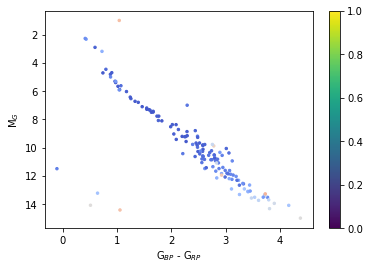

In [20]:
#color magnitude without stars removed from parallax error
nh_stars = nh_stars[nh_stars['parallax_error'] <= 0.34]       #With error filter of .34

cmap = plt.cm.get_cmap("coolwarm")

plt.scatter(nh_stars['bp_rp'], nh_stars['g_abs'], color = cmap(nh_stars['parallax_error']*2), s = 6)

plt.colorbar()
plt.gca().invert_yaxis()

plt.xlabel('G$_{BP}$ - G$_{RP}$')
plt.ylabel('M$_G$')

plt.savefig("nh_stars_error_removed.png")

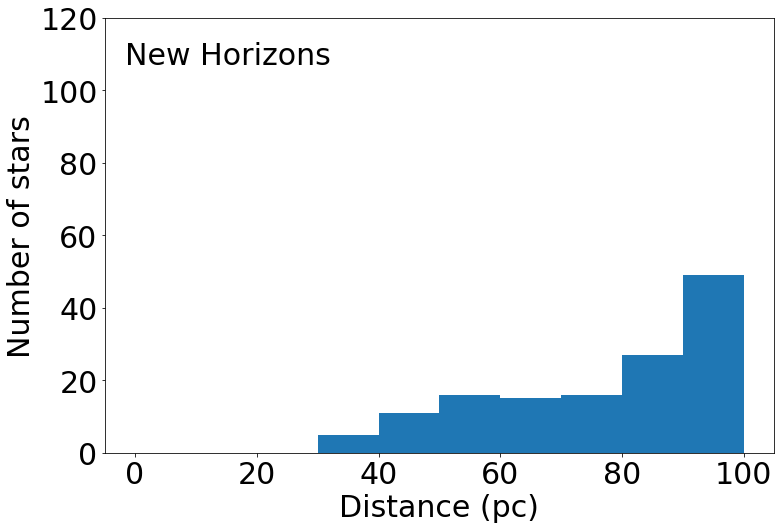

In [21]:
nh_stars = pd.read_csv('nh_results.csv') #get csv

plt.rcParams.update({'font.size': 30})
plt.figure(figsize=(12, 8))

plt.hist(abs(1000/nh_stars['parallax']), bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]) #plot parallax (mas) converted to distance (pc) in histogram

plt.xlabel("Distance (pc)")
plt.ylabel("Number of stars")
plt.figtext(0.268, 0.8, "New Horizons", wrap=True, horizontalalignment='center')

plt.ylim(0, 120)

plt.savefig("nh_stars_dist.png")
plt.show()

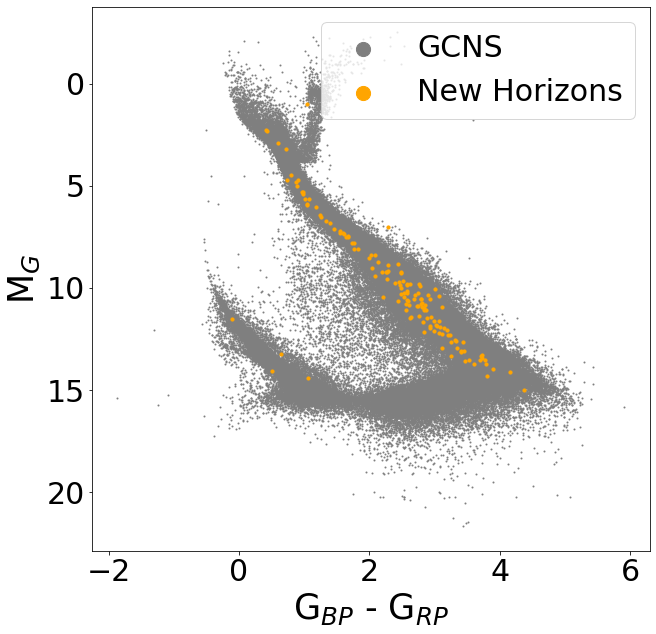

In [22]:
#HR with gcns in background

gcns = pd.read_csv('gcns_total.csv') #all stars in the GCNS database

plt.figure(figsize=(10, 10))

plt.scatter(gcns['bp_rp'], gcns['g_abs'], c = 'tab:gray', s = 1, label = "GCNS")
plt.scatter(nh_stars['bp_rp'], nh_stars['g_abs'], c = 'orange', s = 10, label = "New Horizons")

plt.gca().invert_yaxis()
plt.xlabel('G$_{BP}$ - G$_{RP}$', fontsize=35)
plt.ylabel('M$_G$', fontsize=35)

lgnd = plt.legend(loc='upper right')
lgnd.legendHandles[0]._sizes = [200]
lgnd.legendHandles[1]._sizes = [200]

plt.savefig("nh_superset_hr.png")
plt.show()

In [23]:
star_results = pd.read_csv('nh_results.csv')
star_results_error = pd.read_csv('nh_results_error.csv')

star_results['time_total'] = star_results['time_total']/86400 #convert total time from seconds to hours
star_results_error['time_total'] =  star_results_error['time_total']/86400

print(star_results)
print(star_results_error)

star_results.to_csv('nh_results.csv')
star_results_error.to_csv('nh_results_error.csv')

     Unnamed: 0            source_id          ra        dec      g_abs  \
0             0  3618803417701443072  208.801742  -8.707085   9.196508   
1            11  3618810628952377216  208.777721  -8.624116  10.280616   
2            16  3618810628950468736  208.778338  -8.622554   6.726190   
3            21  3619803629685075840  207.085235  -8.039468   9.887569   
4            28  3619804557398012544  207.011389  -8.030281  10.729146   
..          ...                  ...         ...        ...        ...   
134        3359  4083653599374456832  288.284907 -20.421038  10.452149   
135        3436  4083653603675326080  288.288150 -20.421883   2.905939   
136        3669  4082923283128273536  288.676648 -20.430842  12.202941   
137        3738  4083676384182912128  288.723578 -20.323405   9.784625   
138        4397  4082930223797532160  289.041144 -20.245098  10.522338   

        bp_rp   parallax  parallax_error       dist                      date  \
0    2.483362  28.743696      